# Classification with Dirichlet prior

In [465]:
%load_ext autoreload
%autoreload 2
import site
import time
site.addsitedir('..')

import jax
from jax.config import config
import jax.numpy as jnp
import numpy as np
from  matplotlib import pyplot as plt
from tqdm import tqdm

from jax.scipy.special import gammaln
from jax import random

from src.algorithm import mcmc

plt.rcParams["figure.figsize"]=6,6
#config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [632]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, *subkeys = random.split(key, 5)

In [633]:
K = 3
N = 1000
sigma = 0.05
alpha = 0.7 * jnp.ones(K,)
alpha = jnp.array([10,10,2])

In [634]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape = (N,))
print(f"pi = {pi}")

pi = [0.48659846 0.3089947  0.20440675]


x = [0.3647757  1.0305918  0.61615074]


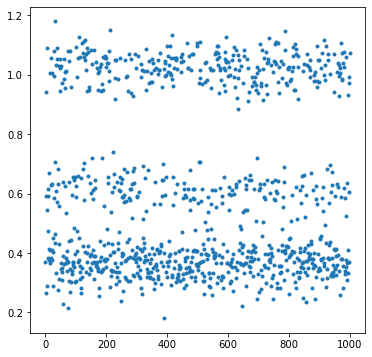

In [635]:
x = random.normal(subkeys[2], shape = (K,))
y = x[z] + sigma * random.normal(subkeys[3], shape = (N,))

print(f"x = {x}")
_ = plt.plot(y, '.')

### The posterior and proposal functions

In [765]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) *  (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
      
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) 
   
# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    n_ik_z = jax.vmap(lambda i : n_ik[i, z[i]])(jnp.arange(N))
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)
    term2 = jnp.sum(jnp.log(n_ik_z + alpha[z])) 

    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

    return term1 + term2 - jnp.sum(x**2) + logPZalpha 


def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [766]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior
    
    p(x_1, ..., x_K | y_1, ..., y_N)
    
    with marginalization over z_1,...z_N."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.uniform(key) * 2*B-B
    x1 = x0.at[idx].set(newval)
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0    
               

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""
    
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.
    
    The returned vector z1 is equal to z0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
   
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

### Sample x

In [767]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.48659846 0.3089947  0.20440675]
x = [0.3647757  1.0305918  0.61615074]


In [639]:
#z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, loss = 85.23408508300781, a = 0.0
  MCMC sample 2000, loss = 85.23408508300781, a = 0.0
  MCMC sample 3000, loss = 85.23408508300781, a = 0.0
  MCMC sample 4000, loss = 185.5463409423828, a = 0.0
  MCMC sample 5000, loss = 208.03662109375, a = 0.0
  MCMC sample 6000, loss = 208.03662109375, a = 0.0
  MCMC sample 7000, loss = 208.03662109375, a = 0.0
  MCMC sample 8000, loss = 208.03662109375, a = 0.0
  MCMC sample 9000, loss = 208.03662109375, a = 0.0
3.4209506511688232 sec
x_samp = [0.448426   0.9185314  0.36871004]
x_true = [0.3647757  1.0305918  0.61615074]


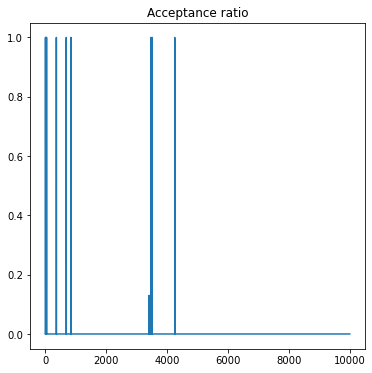

In [640]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 1000, loss = 4385.720703125, a = 0.0
  MCMC sample 2000, loss = 4385.720703125, a = 0.0
  MCMC sample 3000, loss = 4385.720703125, a = 0.0
  MCMC sample 4000, loss = 4385.720703125, a = 0.0
  MCMC sample 5000, loss = 4385.720703125, a = 0.0
  MCMC sample 6000, loss = 4385.720703125, a = 0.0
  MCMC sample 7000, loss = 4533.69091796875, a = 0.0
  MCMC sample 8000, loss = 4533.69091796875, a = 0.0
  MCMC sample 9000, loss = 4533.69091796875, a = 0.0
16.339656114578247 sec
x_samp = [0.36856055 0.83189607 0.5914993 ]
x_true = [0.3647757  1.0305918  0.61615074]


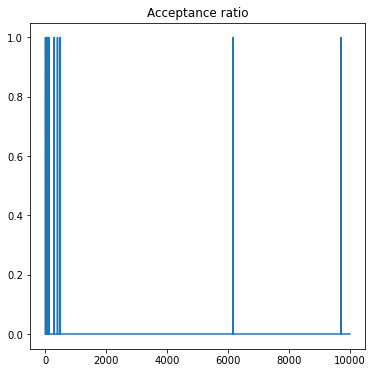

In [641]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### One $x_i$ at a time

  MCMC sample 1000, loss = 16351.21484375, a = 0.0
  MCMC sample 2000, loss = 16349.4375, a = 0.0
  MCMC sample 3000, loss = 16349.43359375, a = 0.0
  MCMC sample 4000, loss = 16350.0205078125, a = 0.0
  MCMC sample 5000, loss = 16349.4951171875, a = 0.0
  MCMC sample 6000, loss = 16349.720703125, a = 0.0
  MCMC sample 7000, loss = 16349.73046875, a = 0.0
  MCMC sample 8000, loss = 16350.5830078125, a = 0.0
  MCMC sample 9000, loss = 16349.4375, a = 0.0
  MCMC sample 10000, loss = 16350.0439453125, a = 0.0
16.20525884628296 sec
x_samp = [ 0.61075014 -0.7933355   0.6255448 ]
x_true = [0.3647757  1.0305918  0.61615074]


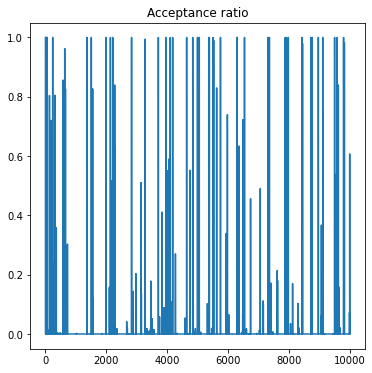

In [642]:
N_samples_x = 10001
B = 3

idx = 2
x0 = jnp.array(np.random.randn(K))

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

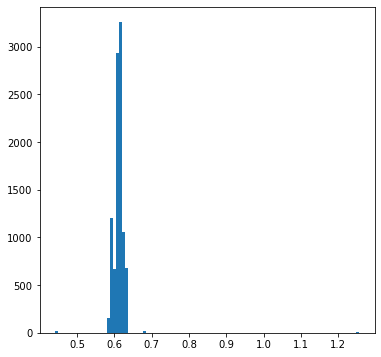

In [643]:
nbins=100
counts, bins = np.histogram(x_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

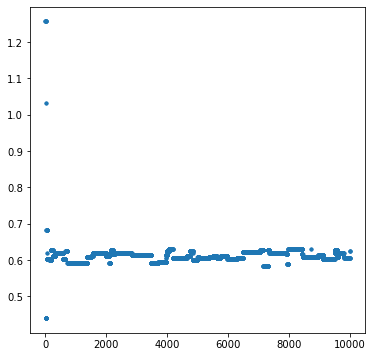

In [644]:
plt.plot(x_samples[:,idx],'.')

### Sample z

  MCMC sample 1000, loss = 1408.636962890625, a = 0.00019259295368101448
4.277124881744385 sec
z[idx]_samp = 0
z[idx]_true = 0


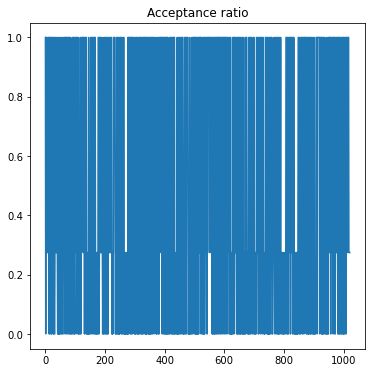

In [645]:
N_samples_z = 1023
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = z.at[idx].set(np.random.randint(0,K,())

B = 3
idx = 10
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}

key, subkey = random.split(key)

t0 = time.time()
z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)

z_samples = z_samples[:,idx]

print(f"{time.time()-t0} sec")
plt.plot(z_r); plt.title("Acceptance ratio")
print(f"z[idx]_samp = {z_samples[N_samples_z-2]}")
print(f"z[idx]_true = {z[idx]}")


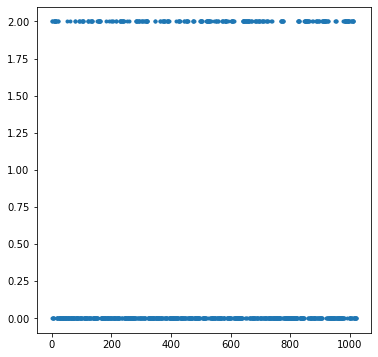

In [646]:
plt.plot(z_samples, '.')

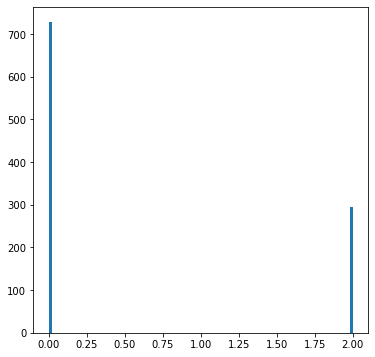

In [647]:
nbins=100
counts, bins = np.histogram(z_samples, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [768]:
N_iters = 6
N_samples_z = 15
N_samples_x = 1001
B = 3

sample_x = True
sample_z = True

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")
        for idx_x in jnp.arange(K):

            params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx_x}
            #params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha}

            key, subkey = random.split(key)
    
            #t0 = time.time()
            x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, xi, N_samples_x, params_x, 1, 1) 
            #x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1) 

            xi = x_samples[N_samples_x - 2]
    
    if sample_z:
        print("  Sampling z")
        for idx_z in tqdm(jnp.arange(N)):
            
            params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}

            key, subkey = random.split(key)

            z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)

            zi = z_samples[N_samples_z - 2]

print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 1000, loss = 2149.96826171875, a = 0.0
  MCMC sample 1000, loss = 324.4058837890625, a = 0.0
  MCMC sample 1000, loss = 2986.5810546875, a = 0.0
  Sampling z


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.28it/s]


Iter = 1
  Sampling x
  MCMC sample 1000, loss = 3081.1533203125, a = 0.0
  MCMC sample 1000, loss = 3134.5751953125, a = 0.0
  MCMC sample 1000, loss = 3134.93505859375, a = 0.0
  Sampling z


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.36it/s]


Iter = 2
  Sampling x
  MCMC sample 1000, loss = 4218.8349609375, a = 0.0
  MCMC sample 1000, loss = 4482.7490234375, a = 0.0
  MCMC sample 1000, loss = 4484.35498046875, a = 0.0
  Sampling z


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.35it/s]


Iter = 3
  Sampling x
  MCMC sample 1000, loss = 5282.1640625, a = 0.0
  MCMC sample 1000, loss = 5311.78466796875, a = 0.0
  MCMC sample 1000, loss = 5311.7861328125, a = 0.0
  Sampling z


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.15it/s]


Iter = 4
  Sampling x
  MCMC sample 1000, loss = 5415.6435546875, a = 0.0
  MCMC sample 1000, loss = 5416.8759765625, a = 0.0
  MCMC sample 1000, loss = 5416.5224609375, a = 0.010021451860666275
  Sampling z


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.22it/s]


Iter = 5
  Sampling x
  MCMC sample 1000, loss = 5387.8759765625, a = 0.0
  MCMC sample 1000, loss = 5387.2197265625, a = 0.0
  MCMC sample 1000, loss = 5387.3486328125, a = 0.0005384287214837968
  Sampling z


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.12it/s]

258.37535524368286 sec
x_samp = [0.4266765 1.0295601 0.8088906]
x_true = [0.3647757  1.0305918  0.61615074]


686
314
0


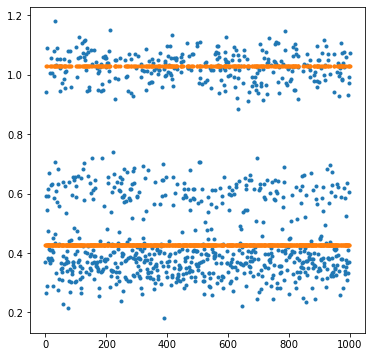

In [769]:
plt.plot(y, '.')
plt.plot(xi[zi], '.')

print(jnp.sum(zi==0))
print(jnp.sum(zi==1))
print(jnp.sum(zi==2))

497
310
193


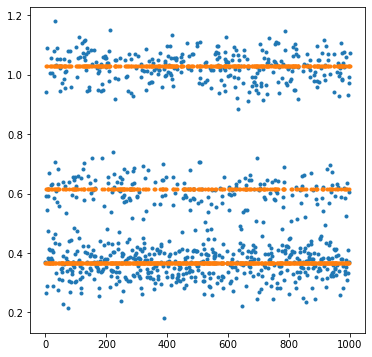

In [770]:
plt.plot(y, '.')
plt.plot(x[z], '.')

print(jnp.sum(z==0))
print(jnp.sum(z==1))
print(jnp.sum(z==2))

In [779]:
print(pi)
print(x)
print(xi)

[0.48659846 0.3089947  0.20440675]
[0.3647757  1.0305918  0.61615074]
[0.4266765 1.0295601 0.8088906]


In [792]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y)**2 * pi[z]

def loss_fun_vmap(x,z,y):
    n_k = calc_nk_jit(z)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))
    #print(f"logPZalpha = {logPZalpha}")
    return jnp.sum(jax.vmap(loss_fun, in_axes = (None, 0, 0))(x,z,y)) + jnp.sum(x**2) - logPZalpha

In [793]:
n_k = calc_nk_jit(z)
logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

In [794]:
jnp.sum(gammaln(n_k+alpha))

DeviceArray(5004.075, dtype=float32)

In [795]:
gammaln(jnp.sum(n_k) + jnp.sum(alpha))

DeviceArray(6057.421, dtype=float32)

In [796]:
alpha.shape

(3,)

In [797]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

1184.2827
660.61743
1055.9011


In [798]:
alpha

DeviceArray([10, 10,  2], dtype=int32)

### Some functions used for debugging - ignore

In [ ]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 11
z1, _, _, _ = proposal_z_one(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])

In [ ]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [ ]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [ ]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [ ]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

In [ ]:
myf(x[0],x[1])

In [ ]:
jnp.max(myf_xy)